# S&P 500 Index Prediction
Workflow:
1. Load the raw data. Transform and save it locally for train
1. Import the three model file and specify the training dataset to train and predict ad-hoc.
2. Retrieve the prediction result from the three models for the next 24 months and apply the ensemble rule.
3. Visualize the ensembled result for the final presentation.

## 0. Prepare the environment
Import the neccesary libraries and model files saved seperately as a .py file.

In [11]:
# import Long Short Term Memory, Convolutional Neural Network and Random Forest model implementation
from ensemble_lstm import AutoLSTM
from ensemble_cnn import AutoCNN
from ensemble_rf import AutoRF

In [12]:
# import necessary package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score, mean_squared_error
import copy
import os
import datetime

In [13]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Download and Load Data
1.   Load feature data from various resources from 1969/8/1 to the most updated and transform it to be predictors
    
    a. Download diffusion index data from https://www.philadelphiafed.org/surveys-and-data/mbos-historical-data into current folder and name it as 'bos_difx.xlsx' 
    
    b. Download GS10, M2, GovernmentBudgetBalance data from https://fred.stlouisfed.org/series/GS10, https://tradingeconomics.com/united-states/money-supply-m2, https://fred.stlouisfed.org/series/M318501Q027NBEAinto current folder and name them as 'GS10.xlsx', 'M2.xlsx', 'GovernmentBudgetBalance.xlsx' respectively 
    
    c. Delete all preceding description and rename date column to 'Date'
    
2.   Load S&P 500 PE Ratio and Price from 1969/8/1 to the most updated and transform it into S&P 500 index as y prediction 

    a. Download S&P 500 PE Ratio and Price from https://www.multpl.com/s-p-500-earnings into current folder 
    
    b. Calculate Earnings per share by dividing Price by PE Ratio 
    
    c. Set SP500-index = (Original EPS/First Values in Series)*100 and name the file as 'S&P500-EPS.xlsx'
    
    d. Delete all preceding description and rename date column to 'Date'
    
3.   Merge above data together using below function


In [14]:
# load both feature data and target variable and merge them into one dataframe, then output it into an excel file 'data.xlsx'
def load_data(feature_files = ['bos_difx.xlsx', 'GS10.xlsx', 'M2.xlsx', 'GovernmentBudgetBalance.xlsx'], target = 'S&P500-EPS.xlsx', output = 'data.xlsx'):
    
    ''' 
    default use diffusion index, GS10, M2, GovernmentBudgetBalance as predictors
    use SP500 index as target variables
    for quarterly data, in this case, GovernmentBudgetBalance, we repeat the data to generate monthly data points
    to align with others 
    '''
    
    curr_path = os.getcwd()
    df_list = []
    # Load feature data from various resources from 1969/8/1 to the most recent date
    for file in feature_files:
        input_path = os.path.join(curr_path,file)
        df = pd.read_excel(
            input_path,
        )
        if file == 'GovernmentBudgetBalance.xlsx':
            df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M')       
            df = df.set_index('Date').resample('M').bfill()
            df = df.reset_index()
            df['Date'] = df['Date'].dt.strftime('%Y-%m-01')
        df['Date'] = pd.to_datetime(df['Date'])
        #df['Date'] = df['Date'].dt.strftime('%Y-%m')
        df_list.append(df)
    
    # Load target data from 'S&P500-EPS.xlsx'
    input_path = os.path.join(curr_path, target)
    eps_df = pd.read_excel(
        input_path,
        header=None,
        skiprows = 1,
    )
    eps_df.columns = ['Date', 'SP500-PE', 'SP500-Price', 'SP500-EPS', 'SP500-Index']
    eps_df = eps_df.iloc[::-1]
    eps_df['Date'] = pd.to_datetime(eps_df['Date'])
    t = eps_df.drop(['SP500-PE', 'SP500-Price', 'SP500-EPS'],1)
    
    # left join features on the target table and rename them
    for df in df_list:
        t = pd.merge(t, df, on = 'Date', how="left")
    # rename columns and drop unneccesary columns
    t = t.rename(columns = {'SP500-Index': 'SP500-EPS-Index', 'GAC': 'ActivityIndex', 'NOC': 'NewOrders', 'SHC': 'Shipments', 'UOC': 'UnfilledOrders',                                                                                                                                                 
                            'DTC': 'DeliveryTime', 'IVC': 'Inventories', 'PPC': 'PricesPaid', 'NEC': 'Employment', 'AWC': 'AverageWorkweek', 'M2SL': 'M2', 'M318501Q027NBEA': 'GovernmentBudgetBalance'}) 
    data = t.drop(['DTF', 'PRC', 'IVF', 'PPF', 'PRF', 'NEF', 'AWF', 'CEF', 'GAF', 'NOF', 'SHF', 'UOF'],1)
    
    data.to_excel(output, index = False)


In [15]:
# load data
load_data()

## 2. Call and train the models
Call the models imported previously and train the models ad-hoc with the dataset saved in the previous section.

In [16]:
tf.get_logger().setLevel('INFO')

# set random seed for reproductivity
seed_value= 2
tf.random.set_seed(seed_value)

# set lags and leads for the rolling windows
lags = [24]*24
lags_cnn = [12]*12+[24]*12

leads = range(1,24+1)

In [25]:
# initiate and train the CNN model
cnn_model = AutoCNN(data_name='data.xlsx', target_name='SP500-EPS-Index')
cnn_model.run(use_target=True, lags=lags_cnn, leads=leads)

# initiate and train the Random Forest model
rf_model = AutoRF(data_name='data.xlsx', target_name='SP500-EPS-Index')
rf_model.run(lags=lags, leads=leads)

# initiate and train the LSTM model
lstm_model = AutoLSTM(data_name='data.xlsx', target_name='SP500-EPS-Index')
lstm_model.run(use_target=True, lags=lags, leads=leads)


## 3. Predict and ensemble the results

In [26]:
# retrieve the prediction results from the three models
# apply the ensemble rule to the predictions
def get_single_forecasting(last_month):
    cnn_future, cnn_actual = cnn_model.get_predict(last_month)
    lstm_future, lstm_actual = lstm_model.get_predict(last_month)
    rf_future, rf_actual = rf_model.get_predict(last_month)

    combined_df_future = pd.DataFrame({'SP500-EPS_CNN_Pred':cnn_future, 'SP500-EPS_LSTM_Pred':lstm_future, 'Period_RF_Pred':rf_future})
    result_future = [(combined_df_future.iloc[0]['SP500-EPS_LSTM_Pred'] + combined_df_future.iloc[0]['SP500-EPS_CNN_Pred'])/2]

    for index in range(1, len(combined_df_future)):

        if combined_df_future.iloc[index]['Period_RF_Pred'] == 0:
            if (combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'] > result_future[index-1]) and (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] > result_future[index-1]):
                    result_future.append(result_future[-1])
            elif (combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'] < result_future[index-1]) and (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] < result_future[index-1]):
                    tmp = (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] + combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'])/2
                    result_future.append(tmp)
            else:
                result_future.append(min(combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'], combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred']))
        else:
            if (combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'] > result_future[index-1]) and (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] > result_future[index-1]):
                    tmp = (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] + combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'])/2
                    result_future.append(tmp)
            elif (combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'] < result_future[index-1]) and (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] < result_future[index-1]):
                    result_future.append(result_future[-1])
            else:
                result_future.append(max(combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'], combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred']))

    plt_date_start = np.array(last_month,dtype=np.datetime64) + 1
    plt_date_end = np.array(last_month,dtype=np.datetime64) + 25
    d = np.arange (plt_date_start, plt_date_end, np.timedelta64 (1,'M'), dtype='datetime64')
    d = d.astype('datetime64[D]') 
    
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(15, 6))
    plt.plot(d, result_future, label='predication')

    plt.legend() 
    plt.title('S&P 500 EPS Index 24 Months Forecasting')
    plt.show()

    return result_future

## 4. Visualize the final output

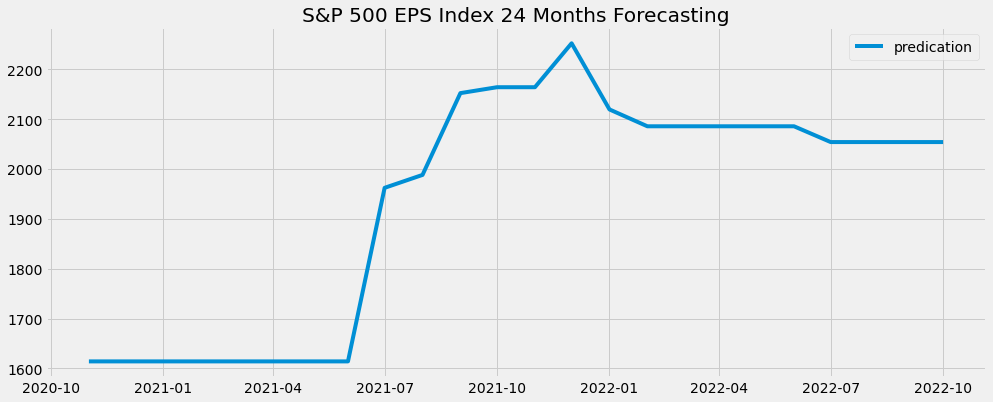

In [28]:
# plot the final output with predicitons from CNN and LSTM
result_future = get_single_forecasting('2020-10')